# Imports

In [5]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model
from scipy.linalg import svd
import sklearn.cluster as cluster
import plotly.express as px
import plotly.graph_objects as go

np.random.seed(1234)

In [6]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Quiz Notes

1 the forecasting problem

# 10.1 Intro to Time-Series Forecasting

Applicable when data admit a time parameter, i.e. they are presented in a sequential manner. Examples:  
- Econometrics - gdp, inflation rates
- Business - forecasting demand and commodity prices

Defining property of time series: **sequential**

2 key models:
- Decomposition
- Autoregressive moving average (ARMA)


# 10.2 Differences in time series data

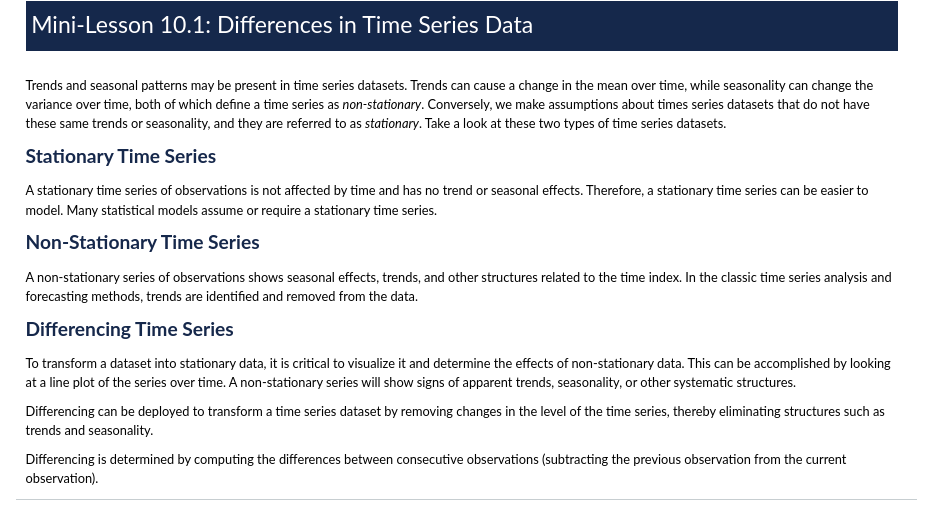

# 10.2 Time-Series Problem Statement

Given historical data, try to predict what will happen over some future time window

Comment on time - methods do not depend on duration of time step (delta t), only on the amount of data available, example
- Make 10-year prediction with 100 years of data, --or--
- Make 10-second prediction with 100 seconds of data
- because same total amount of data

## Example graphic

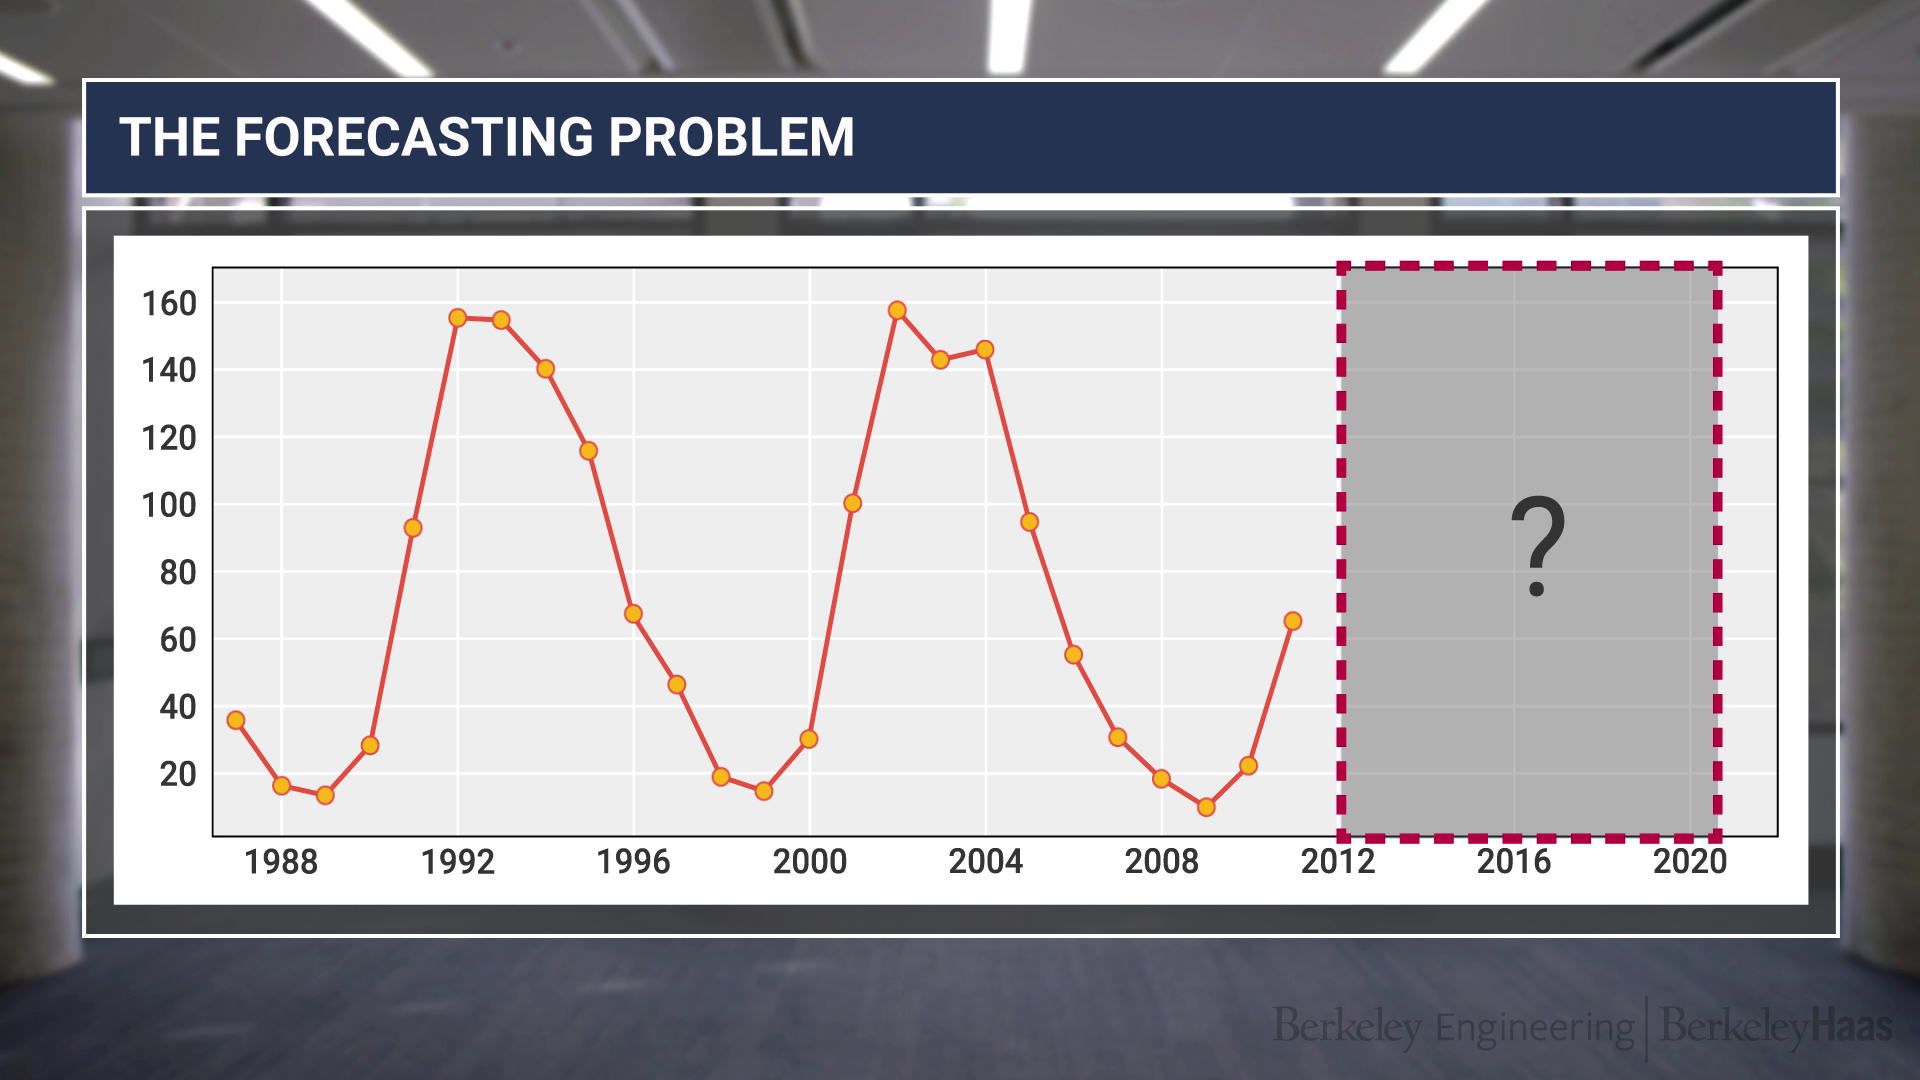

## Steps of forecasting

Four steps:
- Collect historical data
- Train a model
- Use model to make forecast
- Score model - evaluate performance of model once time horizon is past (i.e. truth becomes available)

## Terminology Defined

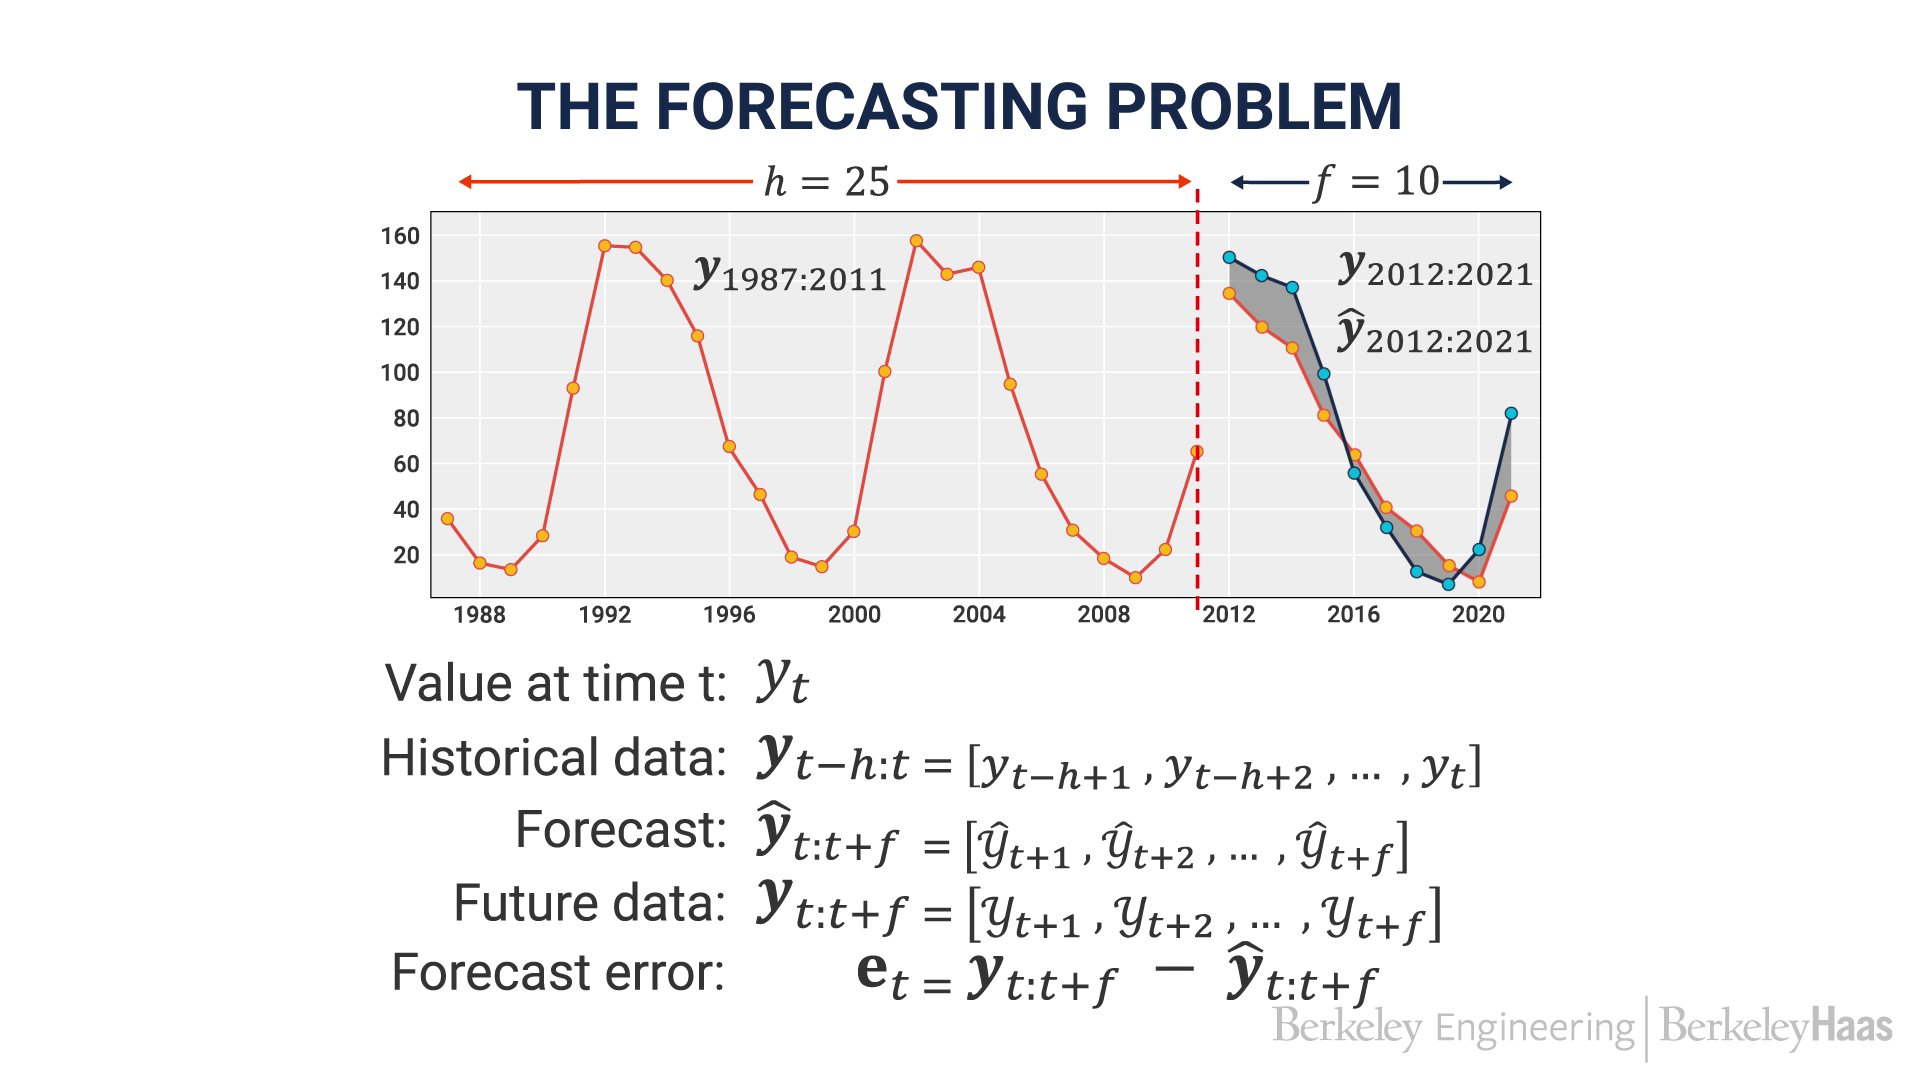

## How to Compress Errors into a Single Value?

2 common choices:
- MAE - mean absolute error - sum of abs of errors
- RMSE - root mean square - square root of sum of squared errors

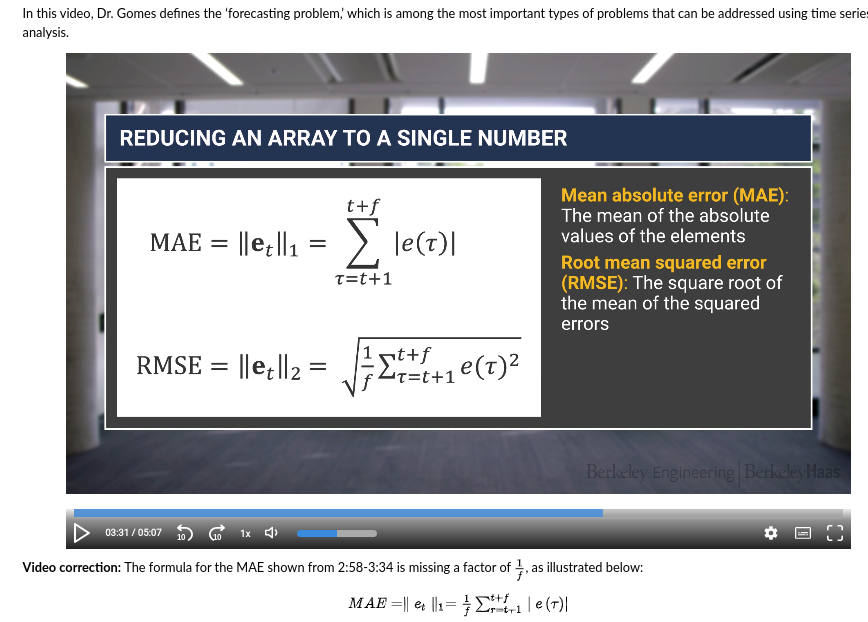

## Forecasting model

Any equation or algorithm that generates forecasts from historical data

# 10.3 Modeling Part 1

Thus far we have described data as having been generated by an unseen PDF, and task had been to infer something about the (unknown) PDF from the data  

Here again same approach, except random variables are organized in a sequential manner, giving rise to a *stochastic process*:
- Stochastic = ordered sequence of random variables
    - n.b.: a **sequence** of random variables
    - whereas a *time series* is a *single sample* from a stochastic process

## 2 key properties of sp

### Stationarity
- Key statistical properties are constant over time
    - Mean, variance, yada yada yada
    - Such that if you focus on a time window of any size, stats are same no matter where window is
    - e.g. if you get a window a "time 1", same distribution as if all time
    - Marginal distribution is Yt on picture

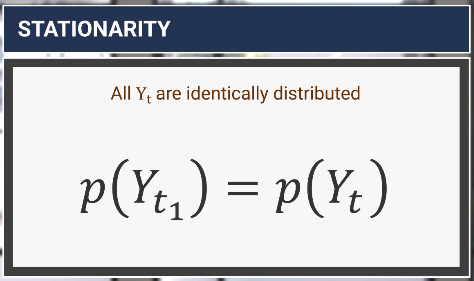


### Independence

Joint probability is product of marginal probabilities. Note here that subscript t is different random variables. Not time?!

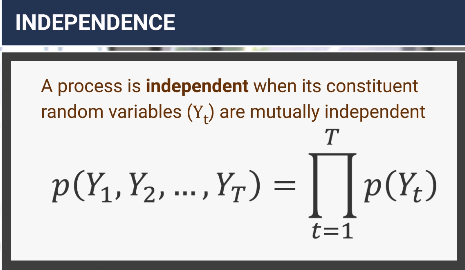

#### Independence of Future on past

Say a future outcome is not influenced by prior outcomes, then prediction now given past same as prediction now

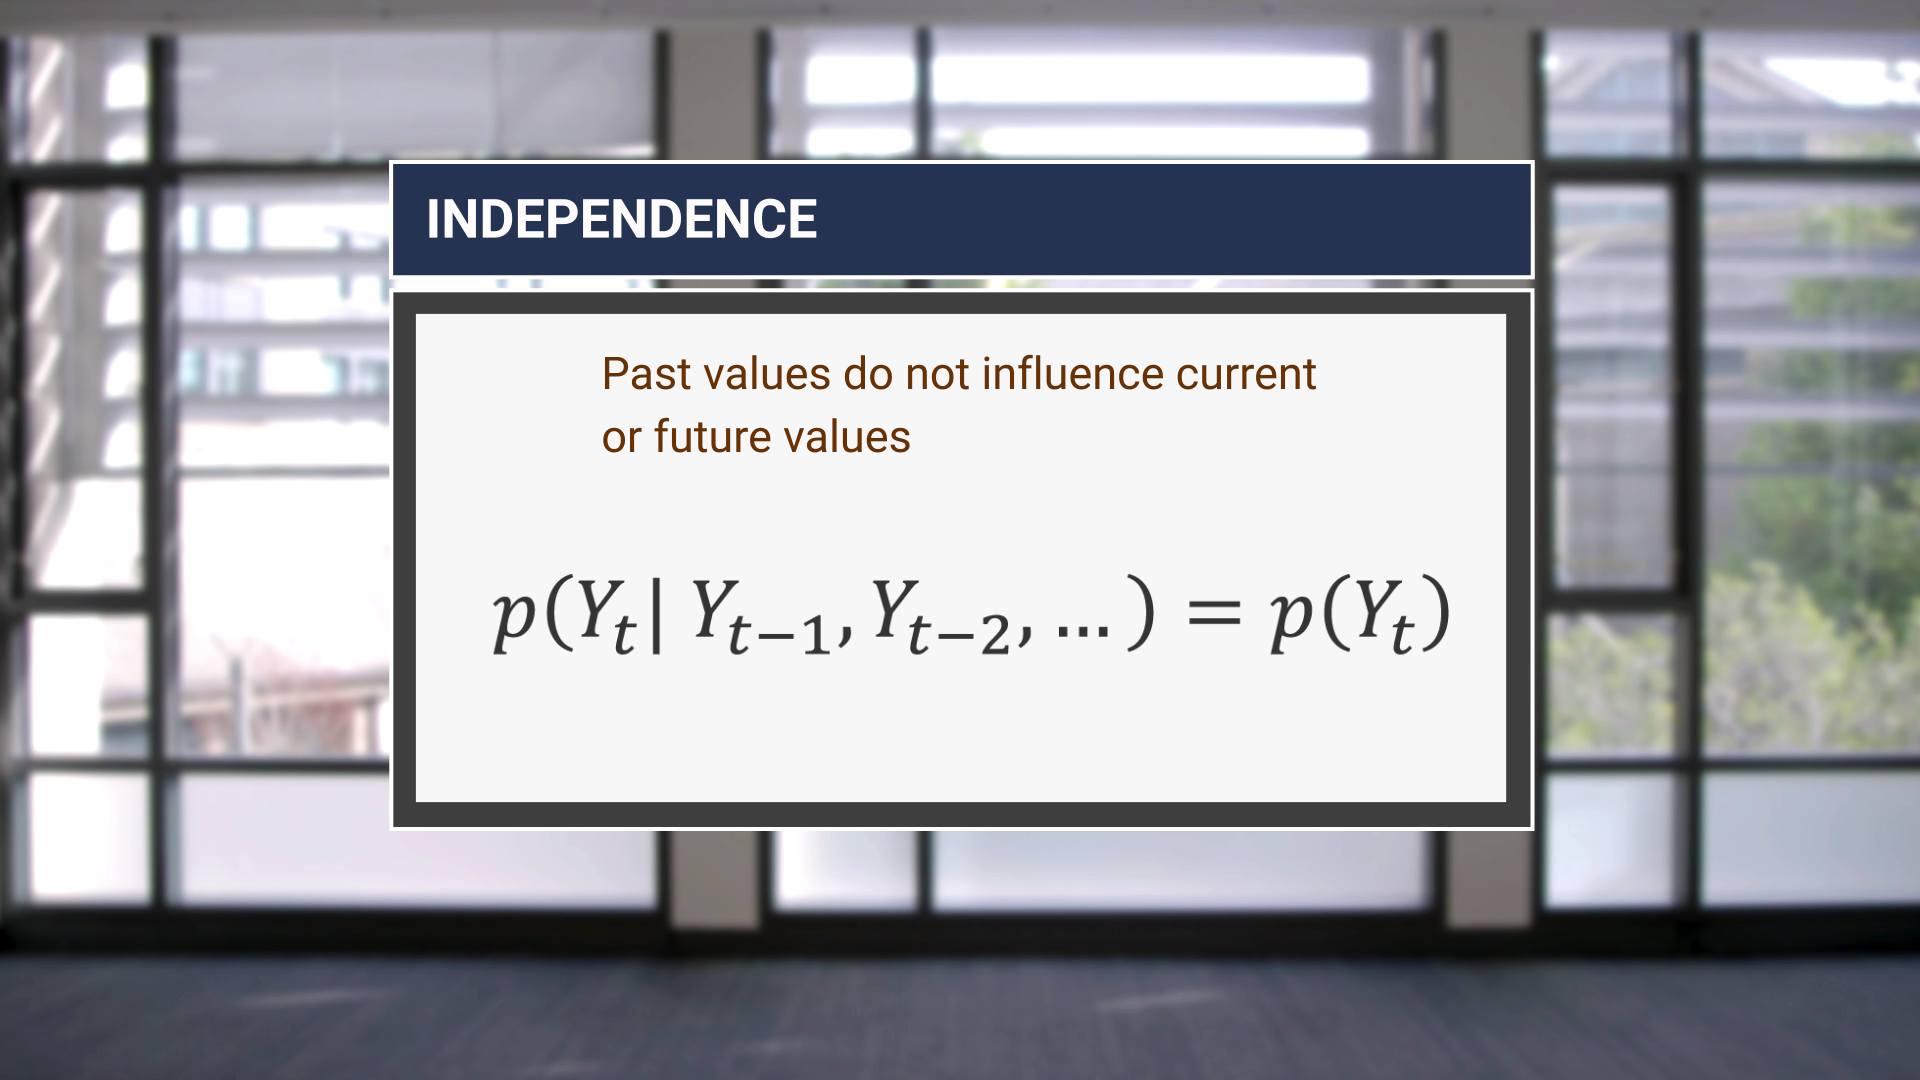

## IID

Processes can be stationary, independent, or stationary and independent
- Independent and identically distributed (IID) is stationary and independent
- Process can also be neither stationary nor independent

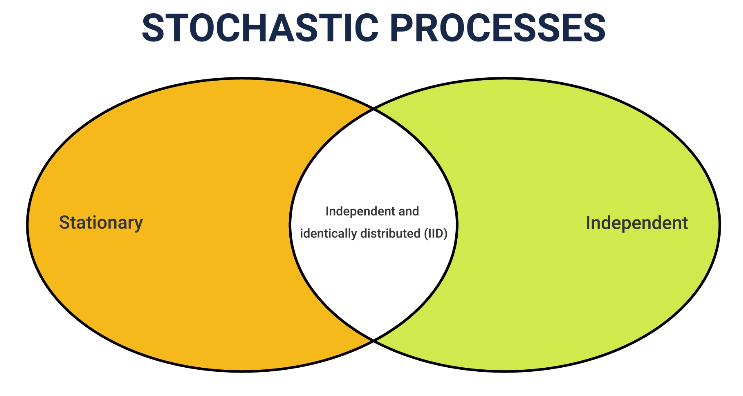

## Special example of IID - Gaussian white noise

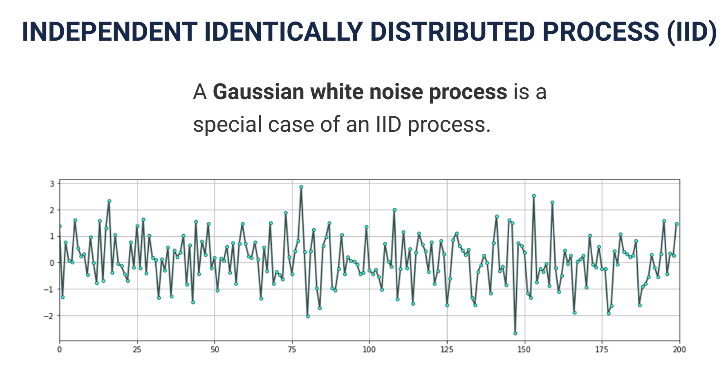

# 10.4 Modeling Part 2

## Autocorrelation Matrix

Key step in estimating correlations between pairs of random variables. Organize into autocorrelation matrix to determine stationarity

As you move out on diagonals, you move the time distance between variable you are estimating
- First diagonal, one time step (see highlighted boxes in picture)
- Second diagonal, second time step
- etc...
- So number of time steps is the unsigned difference between the subscripts

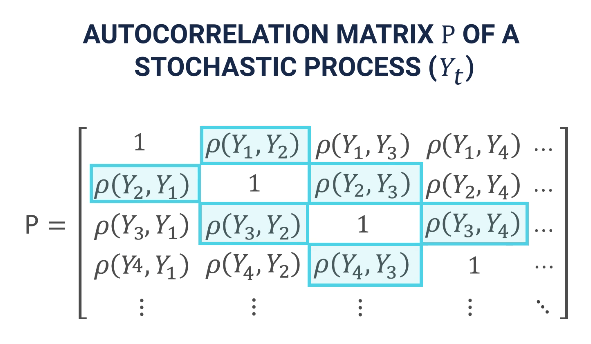

## For a stationary matrix

Stats of any window data the same. So the r1's in the matrix below are all dt = 1, and if stationary then all the same. That is the ACF at time lag = 1.

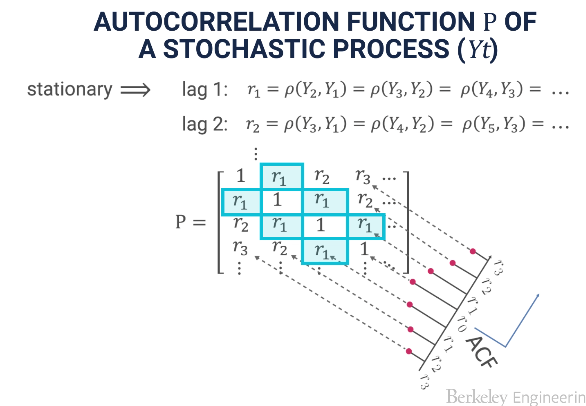

## About the ACF

Tends to decay with lag, meaning data more similar to recent time samples than later ones
- But not always

Can also compute the *sample* autocorrelation function

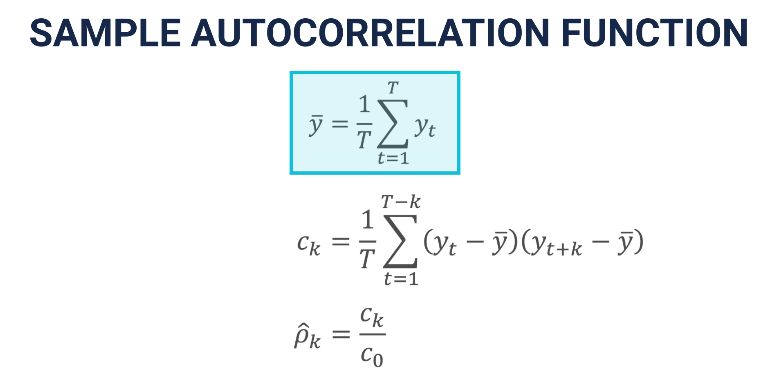

## Some Example ACF's

### Gaussian White Noise (Stationary)

3 plots:
- 1 actual ACF of a white noise process
    - All but lag 0 are 0 becase stationary process
- 2 time sample from this process
- 3 sample ACF
    - Lag 0 again 0 (not surprising since formula with make this true)
    - Remaining samples are close to 0
    - Shaded box shows threshold inside of which regard as 0
    - Height of this box decreases with length of time sample

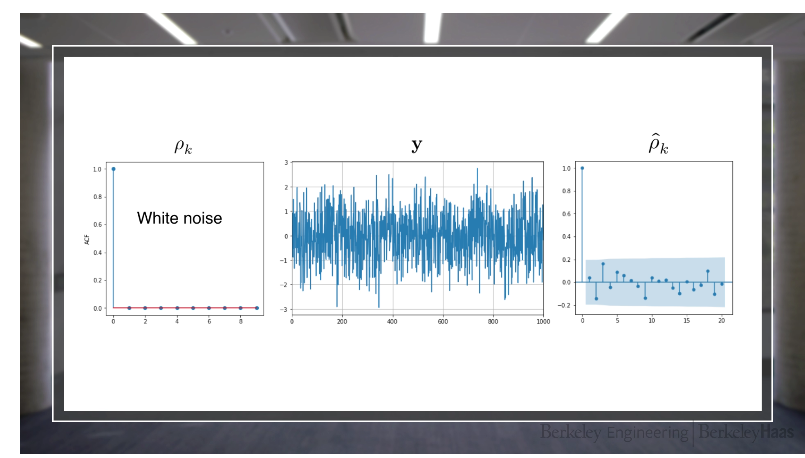

### Non-Stationary

Notice peaking at lag = 10, and time sample shows periodicity of about 10 samples

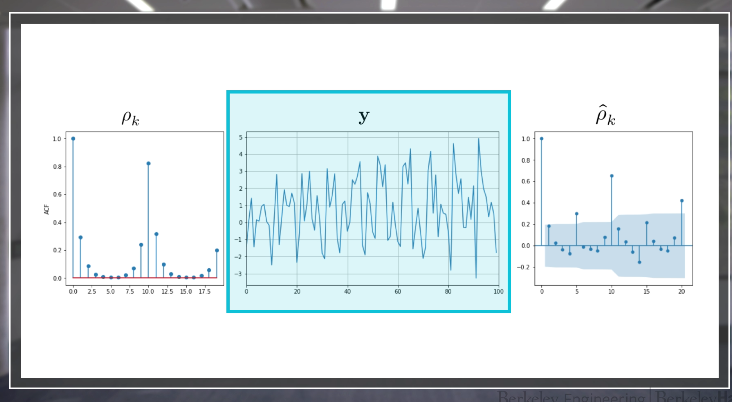

# 10.5 Autocorrelations in Python with statsmodels

In [7]:
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.arima_process as arima_process

## Instantiate Process

In [8]:
process = arima_process.ArmaProcess(
    ar=[1, -0.8], ma=[1]
)  # ar = autoregressive, ma = moving average

process

ArmaProcess([1.0, -0.8], [1.0], nobs=100) at 0x7faee2c7fbe0

## Generate Sample and Plot

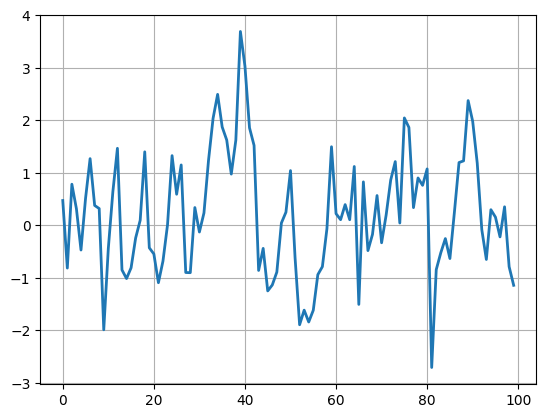

In [9]:
z = process.generate_sample(nsample=100)
plt.plot(z, linewidth=2)

## Plot the Theoretical Autocorrelations

Notice how the decay exponentially with lag
- Which is typical of a stationary process
- Often decay exponentially, or have a few non-zero and then all go to 0

array([1.        , 0.8       , 0.64      , 0.512     , 0.4096    ,
       0.32768   , 0.262144  , 0.2097152 , 0.16777216, 0.13421773,
       0.10737418, 0.08589935, 0.06871948, 0.05497558, 0.04398047,
       0.03518437, 0.0281475 , 0.022518  , 0.0180144 , 0.01441152])

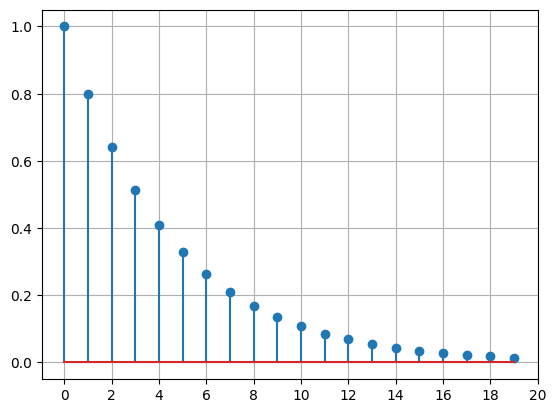

In [10]:
acf = process.acf(lags=20)
display(acf)
plt.stem(acf)
plt.xticks(ticks=range(0, 21, 2))
plt.show()

## Plot Sample Autocorrelations

Looks pretty similar to theoretical ACF for first few points
- After that into the blue area that may be effectively zero
- Cannot reject hypothesis that ACF = 0 in blue region

In [11]:
import statsmodels.graphics.tsaplots as tsaplots

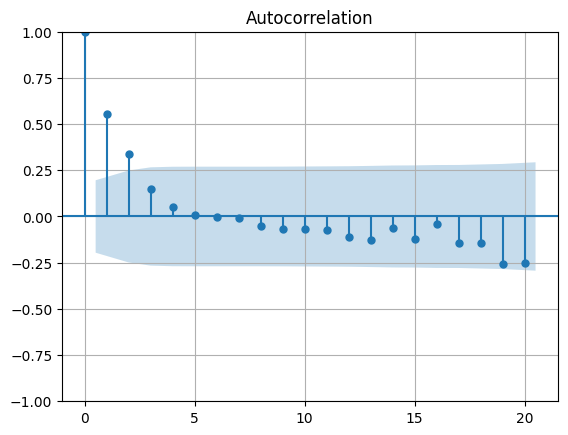

In [12]:
(fix, ax) = plt.subplots()
tsaplots.plot_acf(z, lags=20, ax=ax)
plt.show()

## Sunspots Data

In [13]:
sunspots = pd.read_csv("./data/Sunspots.csv")
sunspots.head()

Unnamed: 0        Date  Monthly Mean Total Sunspot Number
0           0  1749-01-31                               96.7
1           1  1749-02-28                              104.3
2           2  1749-03-31                              116.7
3           3  1749-04-30                               92.8
4           4  1749-05-31                              141.7

In [14]:
sunspots["Date"] = pd.to_datetime(sunspots["Date"])
sunspots = (
    sunspots.set_index("Date")
    .drop(columns=["Unnamed: 0"])
    .rename(columns={"Monthly Mean Total Sunspot Number": "values"})
)
sunspots.head()

values
Date              
1749-01-31    96.7
1749-02-28   104.3
1749-03-31   116.7
1749-04-30    92.8
1749-05-31   141.7

## Plot it

Probably not stationary, since periodic with T = 10

<Axes: xlabel='Date'>

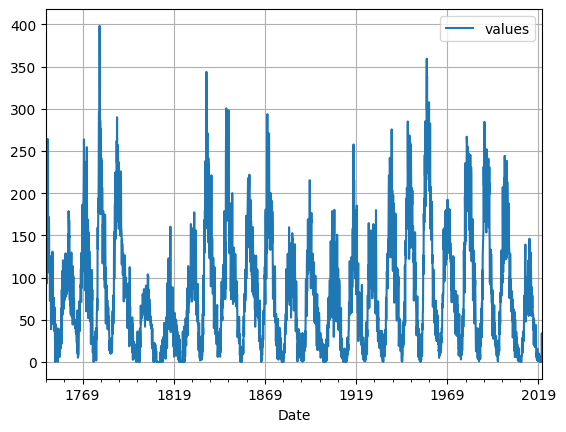

In [15]:
sunspots.plot()

## Compute Sample ACF

Notice does not decay at all --> not stationary

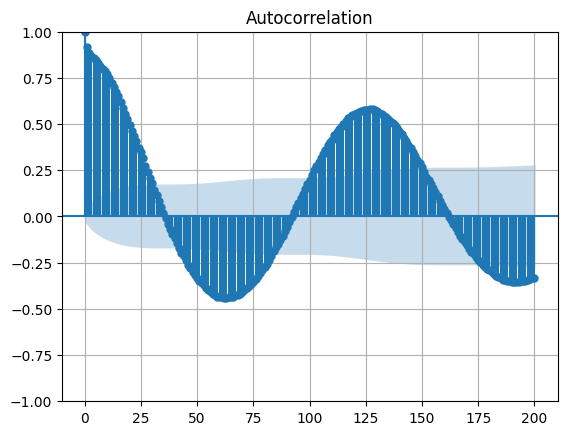

In [16]:
(_, ax) = plt.subplots()
tsaplots.plot_acf(sunspots, lags=200, ax=ax)
plt.show()

# Convert to stationary by taking first difference

You see a couple non-zero values and then pretty much everything zero
So while sunspots is not stationary, difference from one month to next approximately is

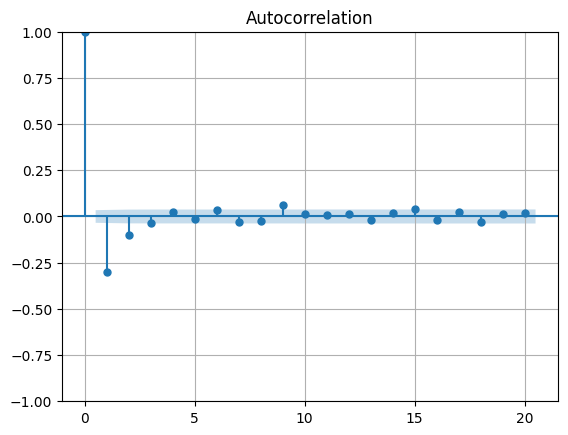

In [17]:
# dvalue = sunspots["values"].to_numpy()[1:] - sunspots["values"].to_numpy()[0:-1]
dvalue = sunspots.diff().dropna()
(fix, ax) = plt.subplots()
tsaplots.plot_acf(dvalue, lags=20, ax=ax)
plt.show()

# Overview of Forecasting by Decomposition

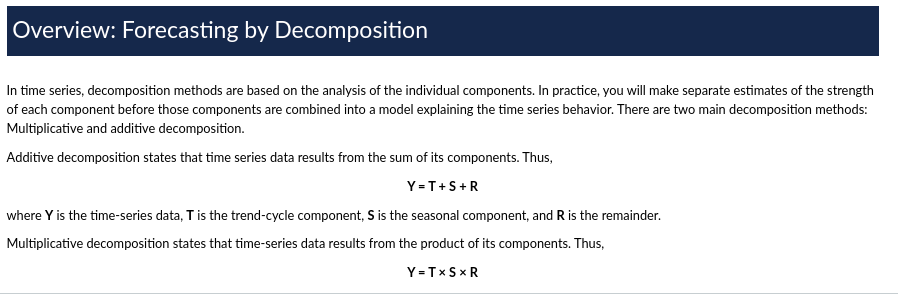

# 10.6 Decomposition Part 1

Some example of time series

nasdaq: upward trend with occasional abrupt drop
sunspots: seaonal, AKA it exhibits periodicity
unemployment: no clear trend, but its variations are not periodic, instead with some random duration it has sharp increase followed by gradual decrease
stationary: pure stationary process, noisy, unpredictable
- Just because stationary does not mean white
- Can still use ACF to make short-term predictions

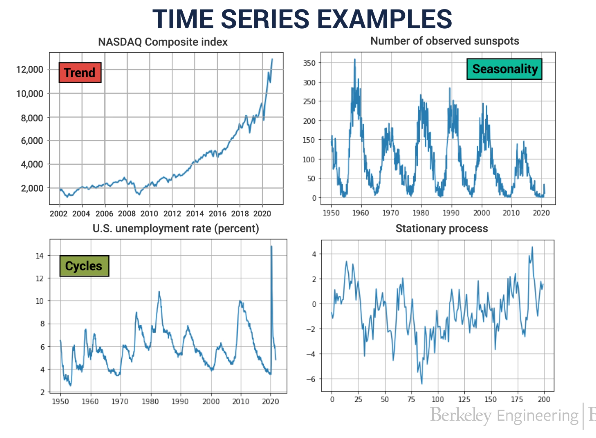

## Video Description

Going to learn how to model long term behavior
- Trend, seasonality, cycles

In another video
- Extract structure from a stationary process using ARMA

## Aproach

In the equation, bold because these are vectors
- y holds the historical data (AKA yt)
- key trait of seasonality is the period is constant and known to the modeler
- cycles break with the trend but not at a set period
- anything else is residue or residual

If signal y is well characterized by the above then residue should be stationary
- No structure
- But may have good structure in a few time steps (get via ACF)

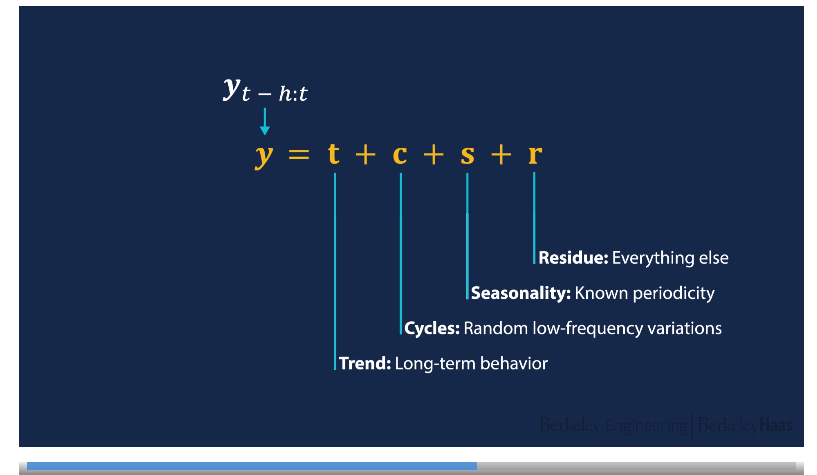

# 10.7 Decomposition Part 2

Approach is as follows

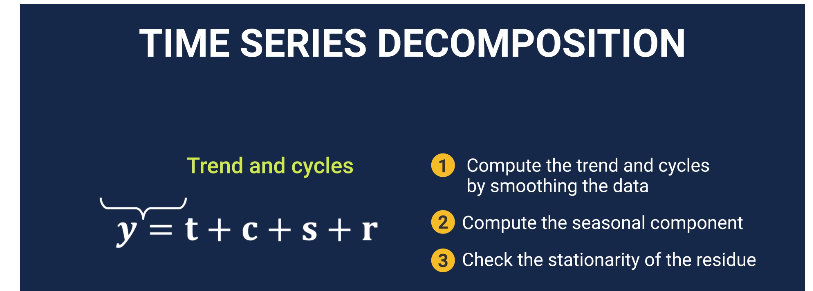

## Data Set - Sunspots

Setup for an example - suppose it is 1984 and you want to predict sunspots for next 15 years

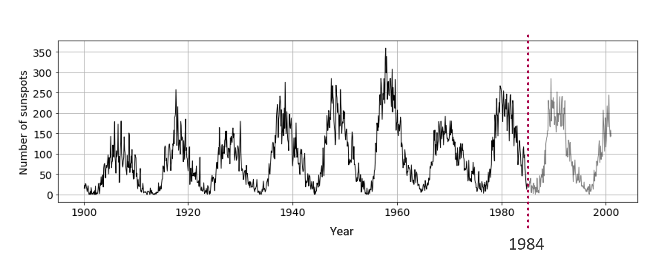

## Steps Outlined

### Trend and Cycles

Run low pass filter on y. f are the filter coefs
- len(f) > len(period)

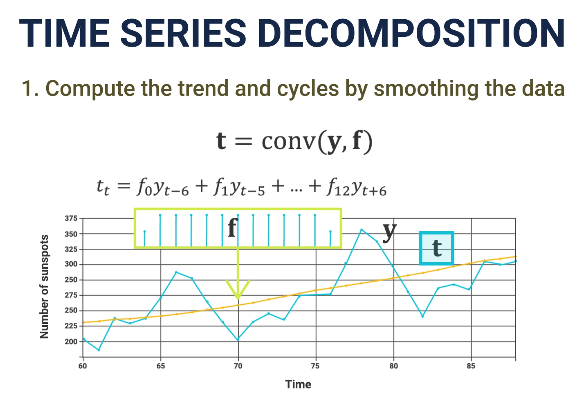

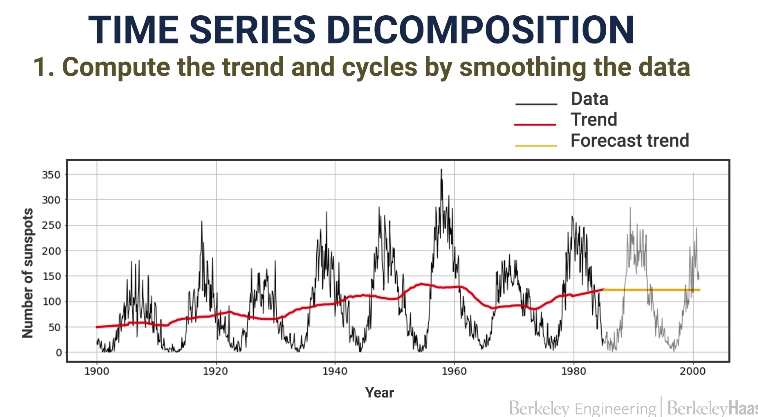

### Seasonal Component

Break up data into sets of length 1 period, then average them together
- Note that this, like all aspects of machine learning, is an *art*

Notice there are variations in the periods, e.g. substantial changes in peak of amplitude of periods (big at 1950, not so much at 1970)
- However, notice some constants
    - Min sunpots nearly zero
    - Peak is about twice the trend

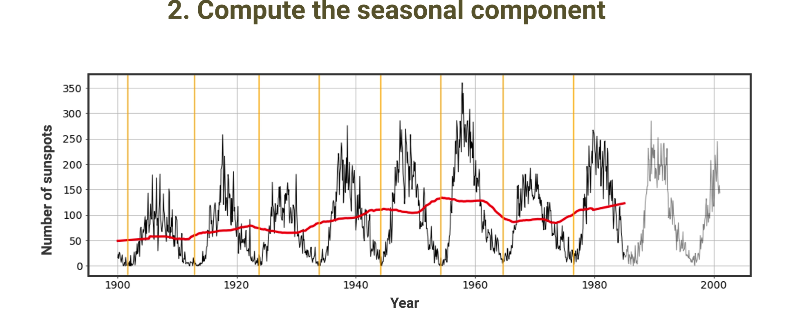

#### Model Adjustment!!

Based on the above observation, replace the additive decomp with a multiplicative decomp, to scale the seasonal component. Instead of
- yhat = t + s
- do
- yhat = t*s

and then scale the seasonal component so that it oscillates between 0 and 2.  
I think what he is saying is use something like  
- `s = alpha*(sin(t) + 1)`

# 10.8 Decomposition Part 3

## Average of Seasons

To recap, have divided the data into 7 seasons of about a decade per season
- Then scaled the season such that its min and max are 0 and 2
- And take its average

Here is the average, it is kind of noisy

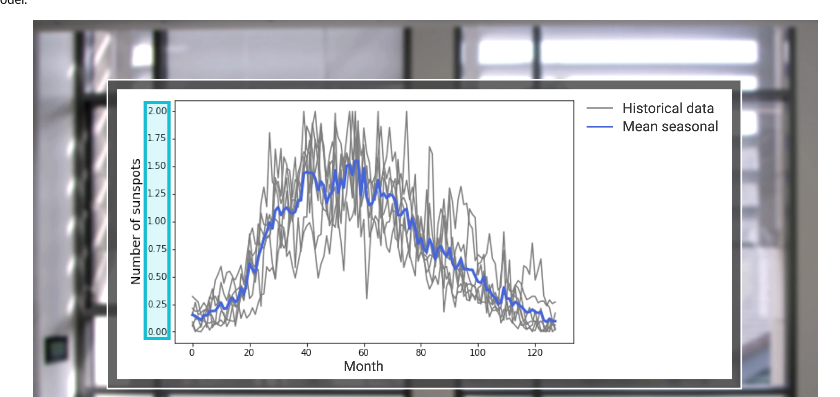

## Smooth the Data before Average

The averaged seasonal data is a bit noisy
- So smooth the data (with filter) and then take its average
- that is - average of filtered data
    - Sidebar - that is same is filter of average b/c such filter is linear operator

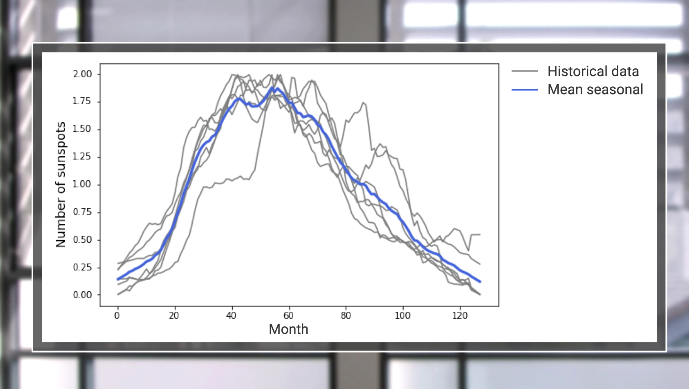

## Remove Outliers from Data

The average of filtered data is still not great
- Remove outliers from filtered data
- Then take its average

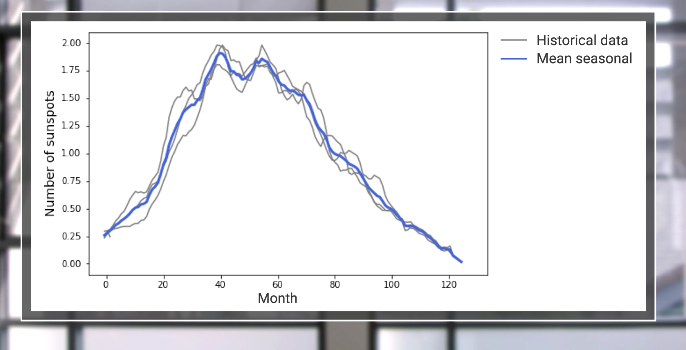

## Final Data is *Template*

Now you can construct the seasonal signal by repeating the template.  
Recap of template extraction:
- Organize by season
- Low pass filter each season
- Remove outliers from set
- Take average of this set

Now repeat this template out to N periods

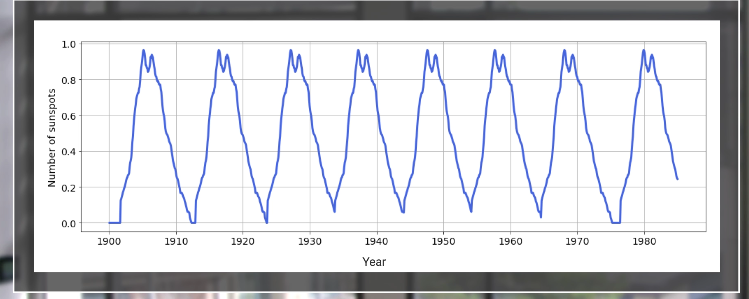

## Add Seasonal Component to Accruing Estimate

Red line is trend only  
Blue is trend*seasonal

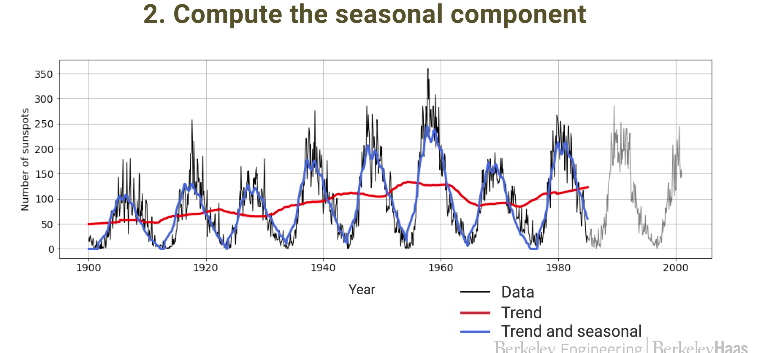

## Last Modeling Step - Get Residue and Examine for Stationarity

Subtract yhat from y to get remainder and check stationarity. How to check?
- Coeffs of autocorrelation function

If residue not stationary, then some part of seasonal or trend remains unmodeled
- Then go back and repeat steps until happy

If is stationary, then there is not much more structure to be extracted

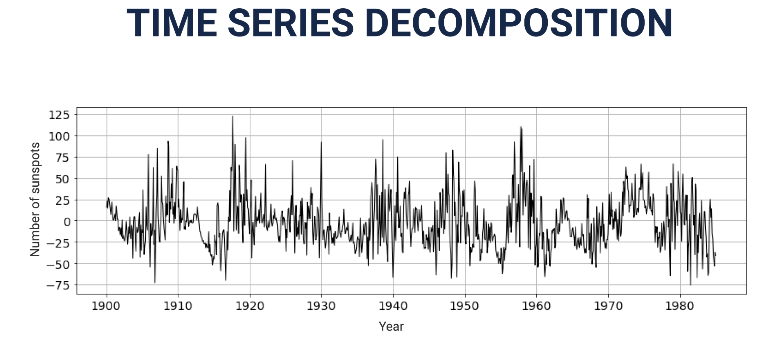

## Make Prediction

Extend seasonal component into future and multiply by extrapolated trend as shown in green

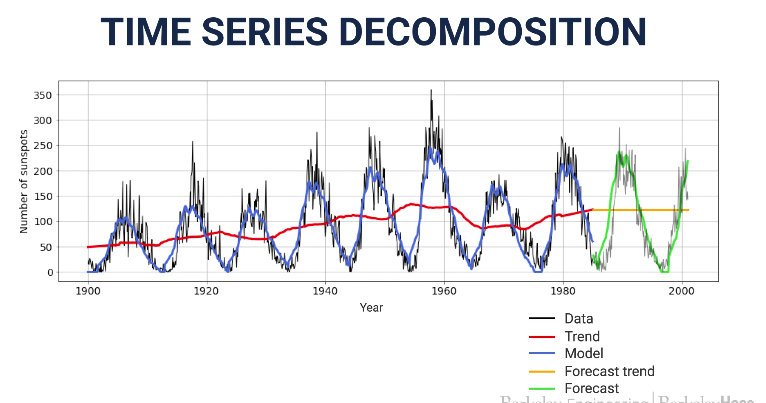

## How to Assess Prediction

Prediction error is same as residue except on future data when obtained

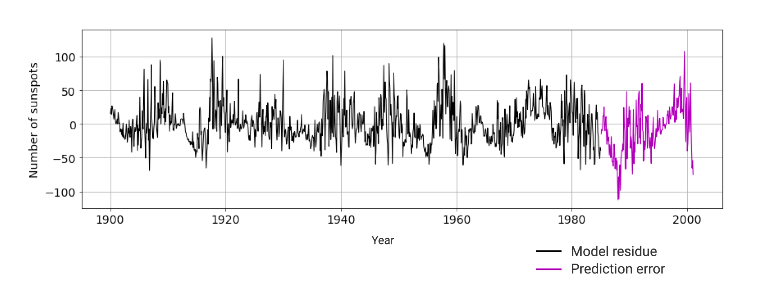

## Error Metrics Again

Something reasonable - residue is smaller than prediction error
- Why is this reasonable?

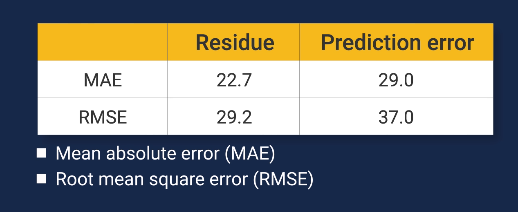

# 10.9 Decomposition Part 4

## Data Load

In [18]:
sunspots = pd.read_csv("./data/Sunspots.csv")
sunspots.head()
sunspots["Date"] = pd.to_datetime(sunspots["Date"])
sunspots = (
    sunspots.set_index("Date")
    .drop(columns=["Unnamed: 0"])
    .rename(columns={"Monthly Mean Total Sunspot Number": "values"})
)
sunspots.head()

values
Date              
1749-01-31    96.7
1749-02-28   104.3
1749-03-31   116.7
1749-04-30    92.8
1749-05-31   141.7

<Axes: xlabel='Date'>

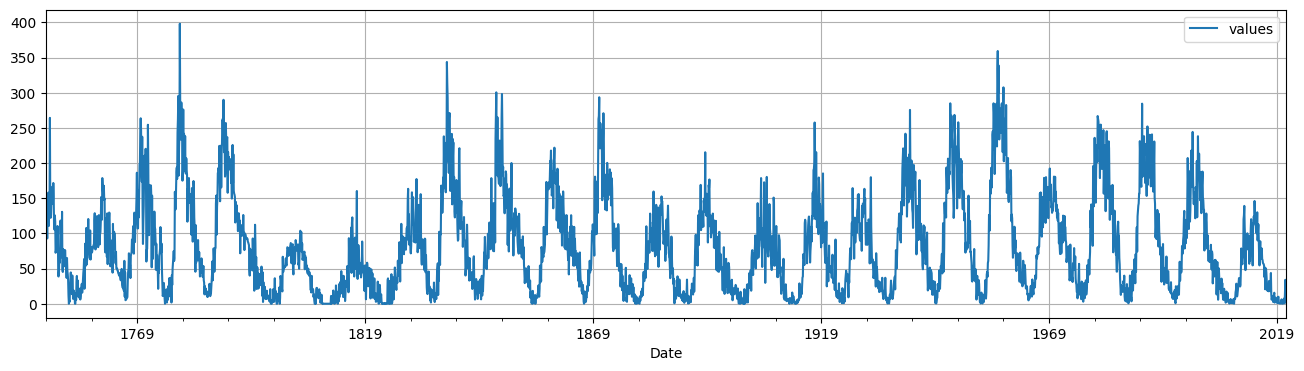

In [19]:
sunspots.plot(figsize=(16, 4))

## Split Historical and Future Data - Cut at 1984

In [20]:
y_hist = sunspots.loc["1900":"1984", "values"]
y_future = sunspots.loc["1985":"2000", "values"]

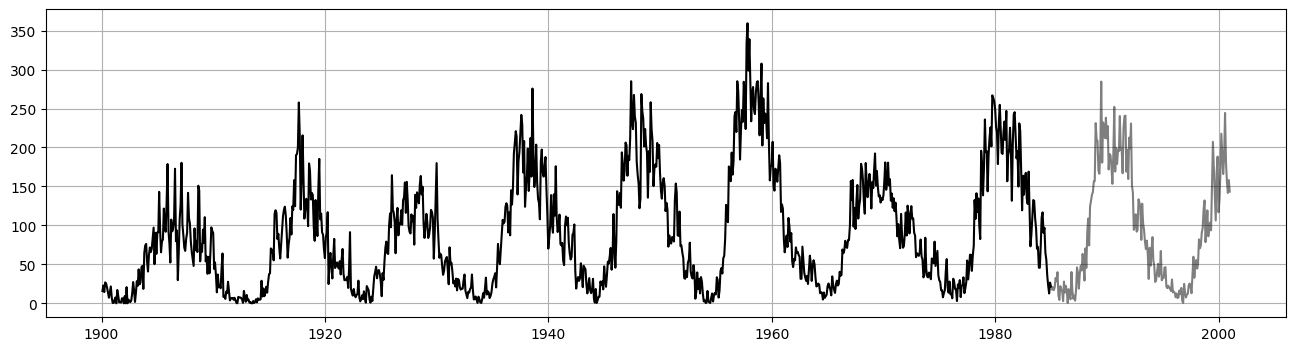

In [21]:
plt.figure(figsize=(16, 4))
plt.plot(y_hist, "k")
plt.plot(y_future, "k", alpha=0.5)
plt.show()

## Extract Parts

### Trend

In [22]:
from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.seasonal import _extrapolate_trend

In [23]:
period = 128
filt = np.ones(period + 1)
filt[0] = 0.5
filt[-1] = 0.5
filt /= period

In [24]:
trend = convolution_filter(y_hist, filt)
trend = _extrapolate_trend(trend, period + 1)

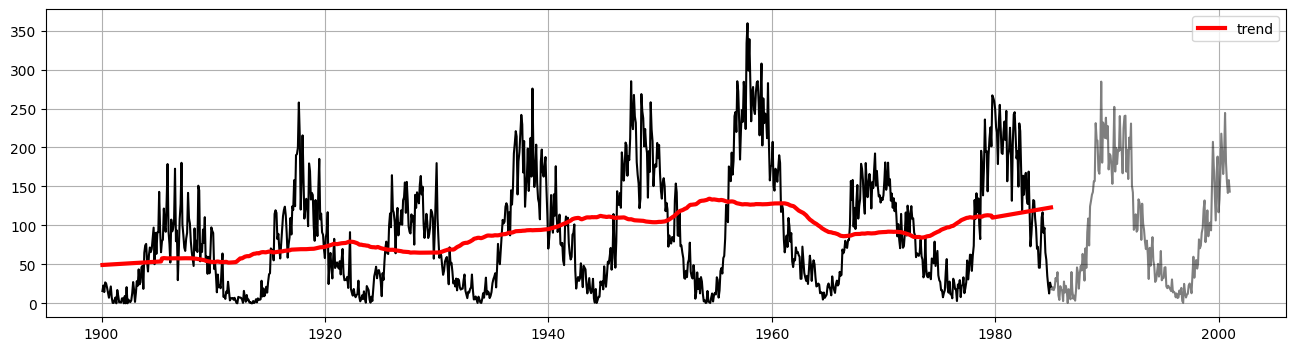

In [25]:
plt.figure(figsize=(16, 4))
plt.plot(y_hist, "k")
plt.plot(y_future, "k", alpha=0.5)
plt.plot(trend, "r", linewidth=3, label="trend")
plt.legend()
plt.show()

### Detrend the Data

In [26]:
detrended = (y_hist - trend).to_numpy()

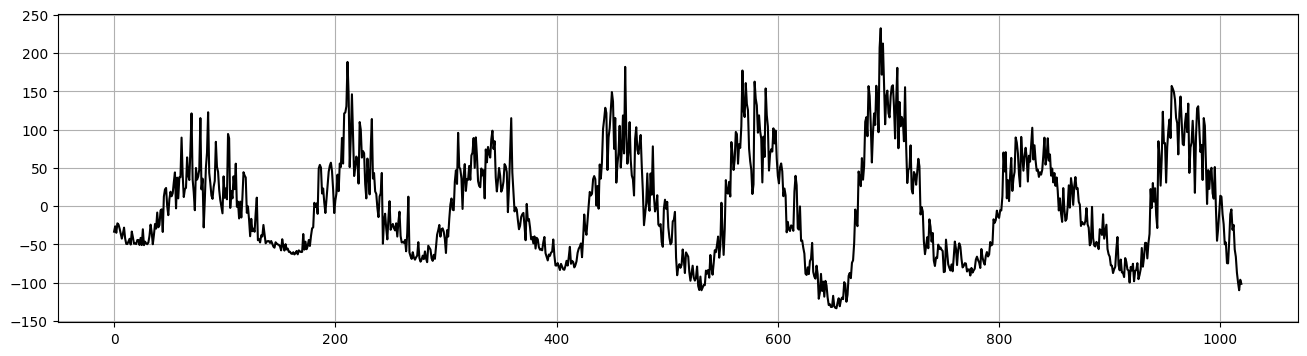

In [27]:
plt.figure(figsize=(16, 4))
plt.plot(detrended, "k")

### Split Data into Seasons

In [28]:
lows_index = [20, 155, 284, 405, 529, 650, 775, 917]
lows = y_hist.index[lows_index]
lows

DatetimeIndex(['1901-09-30', '1912-12-31', '1923-09-30', '1933-10-31',
               '1944-02-29', '1954-03-31', '1964-08-31', '1976-06-30'],
              dtype='datetime64[ns]', name='Date', freq=None)

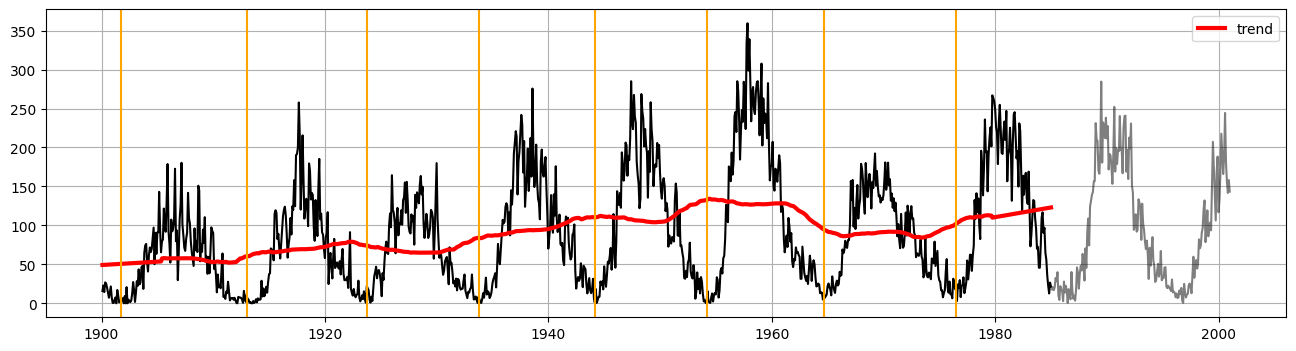

In [29]:
plt.figure(figsize=(16, 4))
plt.plot(y_hist, "k")
plt.plot(y_future, "k", alpha=0.5)
plt.plot(trend, "r", linewidth=3, label="trend")
for low in lows:
    plt.axvline(x=pd.to_datetime(low), color="orange")
plt.legend()
plt.show()

### Divide Detrended Data into Seasons

In [30]:
period = int(np.round(np.mean(np.diff(np.array(lows_index)))))
period

128

In [31]:
num_seasons = len(lows) - 1
seasonals = np.empty((period, num_seasons))
for k in range(num_seasons):
    # scaling such that amplitude is -1, 1
    s = detrended[lows_index[k] : lows_index[k] + period]
    s = 2 * (s - np.min(s)) / (np.max(s) - np.min(s))
    seasonals[:, k] = s

mean_seasonals = seasonals.mean(axis=1)

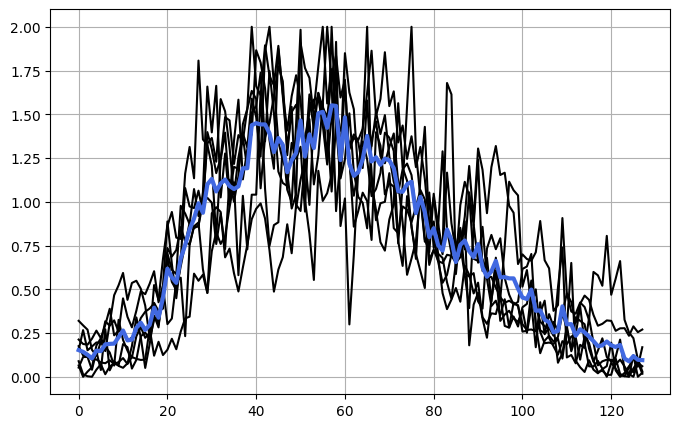

In [32]:
plt.figure(figsize=(8, 5))
for k in range(num_seasons):
    plt.plot(seasonals[:, k], color="k")
plt.plot(mean_seasonals, color="royalblue", linewidth=3)

### Smooth the Seasonal Data

In [33]:
filt_size = 9
filt = np.repeat(1.0 / filt_size, filt_size)

seasonals_smoothed = np.empty((period, num_seasons))
for k in range(num_seasons):
    # scaling such that amplitude is -1, 1
    s = detrended[lows_index[k] : lows_index[k] + period]
    s = _extrapolate_trend(convolution_filter(s, filt), filt_size)
    s = 2 * (s - np.min(s)) / (np.max(s) - np.min(s))
    seasonals_smoothed[:, k] = s

mean_seasonals_smoothed = seasonals_smoothed.mean(axis=1)

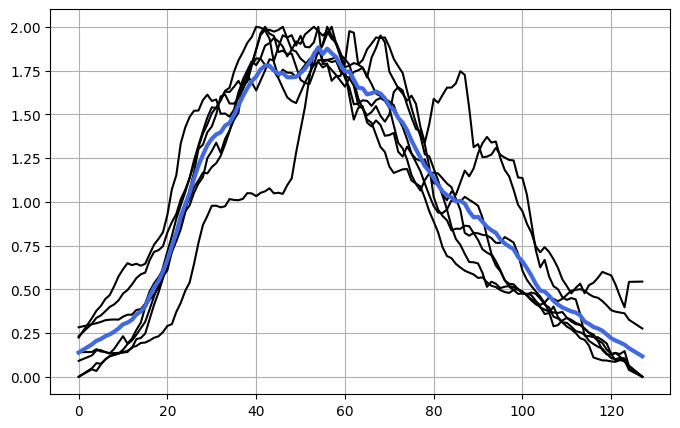

In [34]:
plt.figure(figsize=(8, 5))
for k in range(num_seasons):
    plt.plot(seasonals_smoothed[:, k], color="k")
plt.plot(mean_seasonals_smoothed, color="royalblue", linewidth=3)

### Remove Outlier Seasons

In [35]:
seasonals_smoothed_no_outliers = seasonals_smoothed[:, [2, 3, 4]]
mean_seasonals_smoothed_no_outliers = seasonals_smoothed_no_outliers.mean(axis=1)

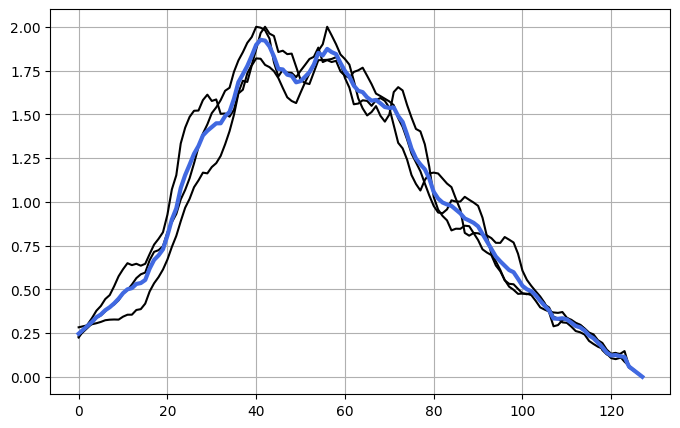

In [36]:
plt.figure(figsize=(8, 5))
for k in range(seasonals_smoothed_no_outliers.shape[1]):
    plt.plot(seasonals_smoothed_no_outliers[:, k], color="k")
plt.plot(mean_seasonals_smoothed_no_outliers, color="royalblue", linewidth=3)

### Build Seasonal Template

In [37]:
seasonal = pd.Series(index=y_hist.index, data=0)
seasonal

for low in lows_index:
    if low + period < len(seasonal):
        seasonal[low : low + period] = mean_seasonals_smoothed_no_outliers
    else:
        seasonal[low:] = mean_seasonals_smoothed_no_outliers[
            : len(seasonal) - (low + period)
        ]
seasonal /= seasonal.max()

In [38]:
seasonal.head()

Date
1900-01-31    0.0
1900-02-28    0.0
1900-03-31    0.0
1900-04-30    0.0
1900-05-31    0.0
dtype: float64

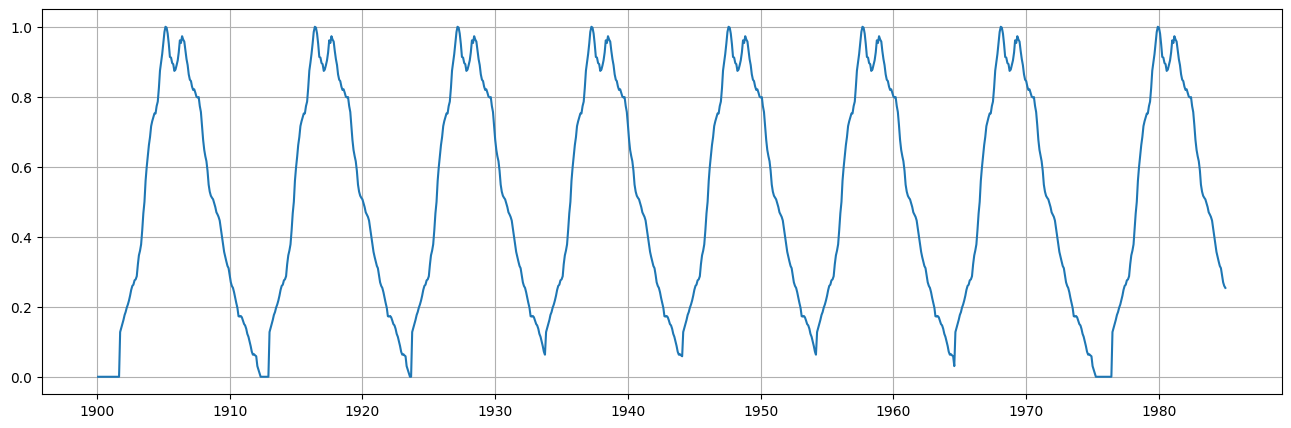

In [39]:
plt.figure(figsize=(16, 5))
plt.plot(seasonal)

## Final Model

In [40]:
season_and_trend = 2 * trend * seasonal

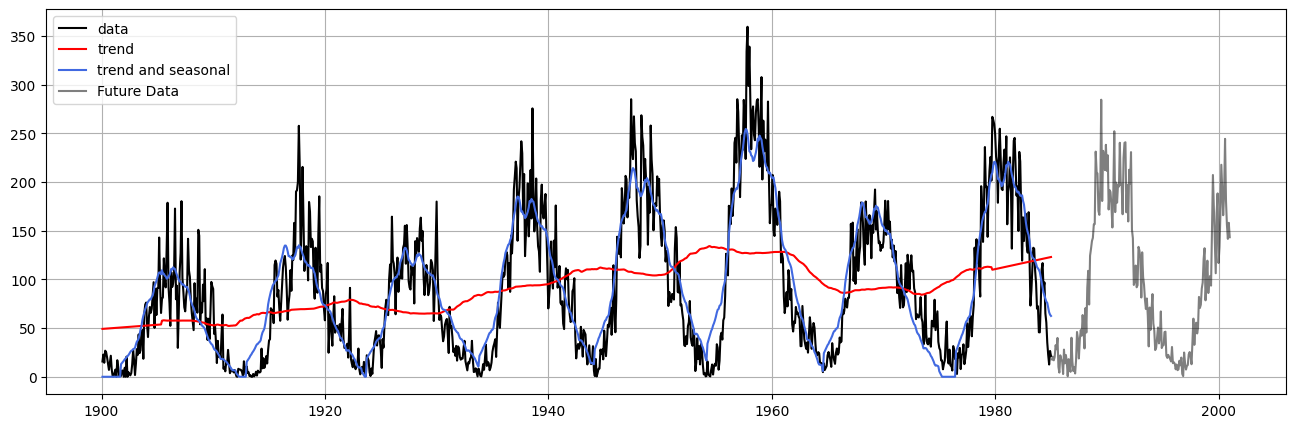

In [41]:
plt.figure(figsize=(16, 5))
plt.plot(y_hist, "k", label="data")
plt.plot(trend, label="trend", color="red")
plt.plot(season_and_trend, label="trend and seasonal", color="royalblue")
plt.plot(y_future, "k", alpha=0.5, label="Future Data")
plt.legend()
plt.show()

## Model Residue

In [42]:
residue = y_hist - season_and_trend

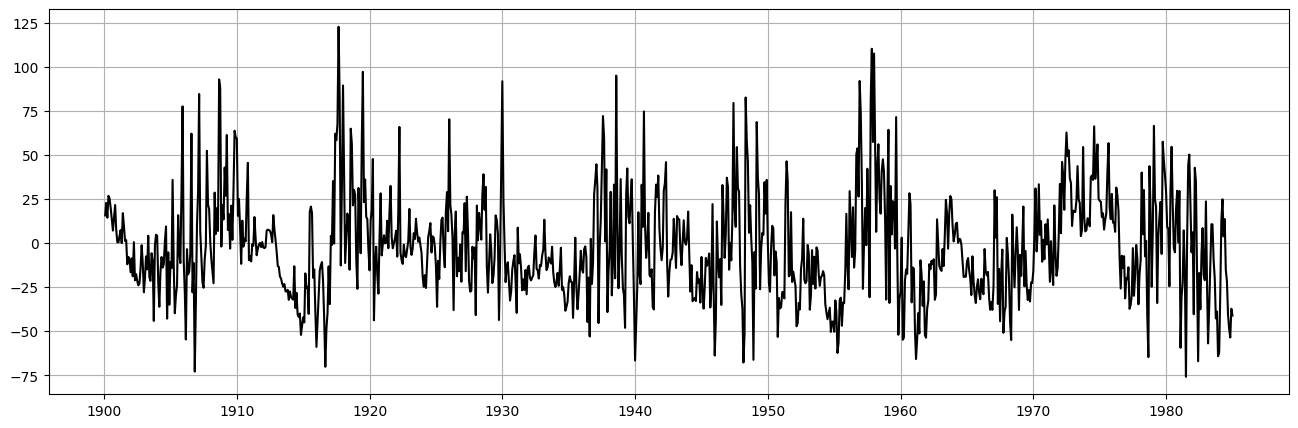

In [43]:
plt.figure(figsize=(16, 5))
plt.plot(residue, "k", label="data")

## Magnitude of Residue

In [44]:
mae = np.abs(residue).mean()
rmse = np.sqrt((residue**2).mean())
[mae, rmse]

[22.72635908805391, 29.218041541672687]

## Stationarity of Residue

Does not look very stationary
- Notice how the ACF does not die off

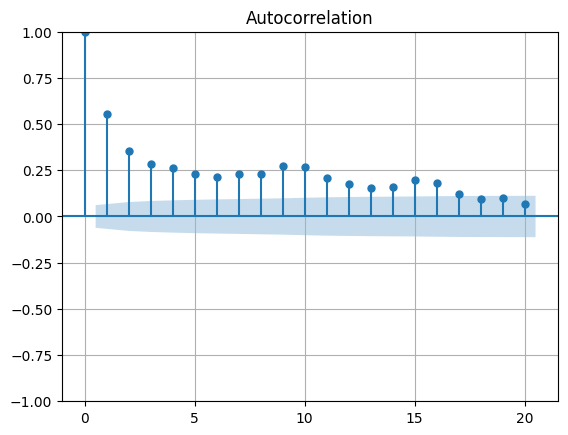

In [45]:
(_, ax) = plt.subplots()
tsaplots.plot_acf(residue, lags=20, ax=ax)
plt.show()

## Forecast with the Model

In [46]:
mean_seasonals_smoothed_no_outliers.shape

(128,)

In [47]:
yhat_trend = pd.Series(index=y_future.index, data=trend[-1])
yhat_seasonal = pd.Series(index=y_future.index, data=0)
for k in range(len(yhat_seasonal)):
    # Homework - what on earth is the following indexing doing??
    idx = -(2 * len(mean_seasonals_smoothed_no_outliers) - k)
    # display([k, idx])
    yhat_seasonal[k] = seasonal[k]
# plt.plot(yhat_seasonal)

In [48]:
yhat = 2 * yhat_trend * yhat_seasonal

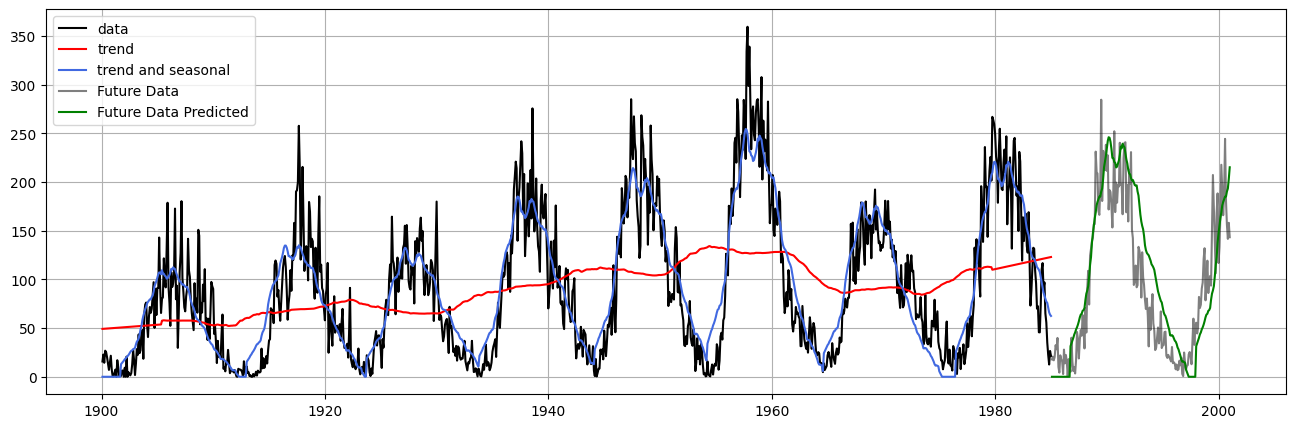

In [49]:
plt.figure(figsize=(16, 5))
plt.plot(y_hist, "k", label="data")
plt.plot(trend, label="trend", color="red")
plt.plot(season_and_trend, label="trend and seasonal", color="royalblue")
plt.plot(y_future, "k", alpha=0.5, label="Future Data")
plt.plot(yhat, "g", alpha=1.0, label="Future Data Predicted")
plt.legend()
plt.show()

## Prediction Error

In [50]:
pred_error = y_future - yhat

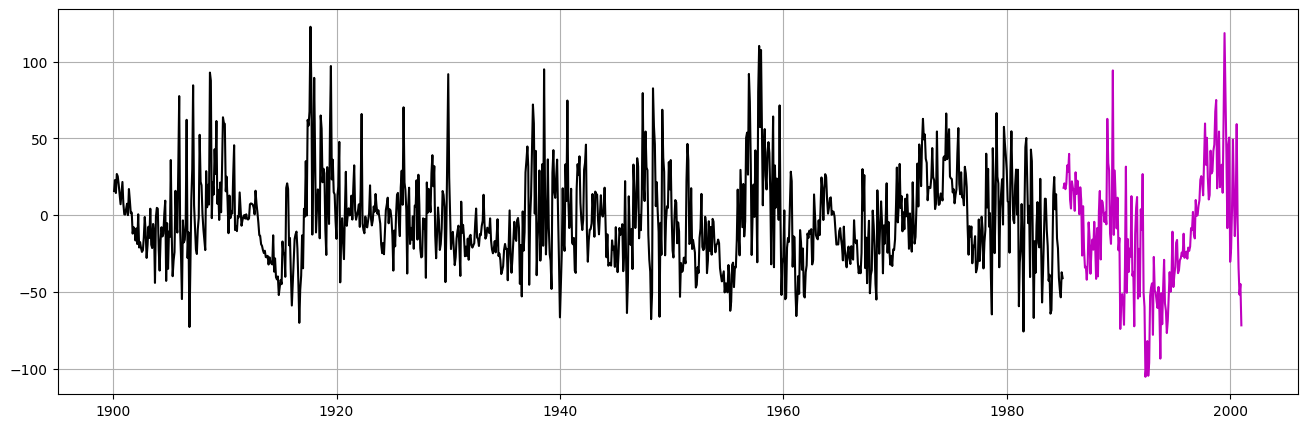

In [51]:
plt.figure(figsize=(16, 5))
plt.plot(residue, "k", label="data")
plt.plot(pred_error, "m", label="data")

## Error Metrics on Prediction

Dr. Gomes calls the errors reaonable because the prediction error should be larger than modeled error
- Otherwise your model would be apparently better at reading the future than describing the past 

In [52]:
mae_pred = np.abs(pred_error).mean()
rmse_pred = np.sqrt((pred_error**2).mean())
display([mae, rmse])
display([mae_pred, rmse_pred])

[22.72635908805391, 29.218041541672687]

[32.73567430618158, 40.54382015980052]

# ARMA Framework Intro

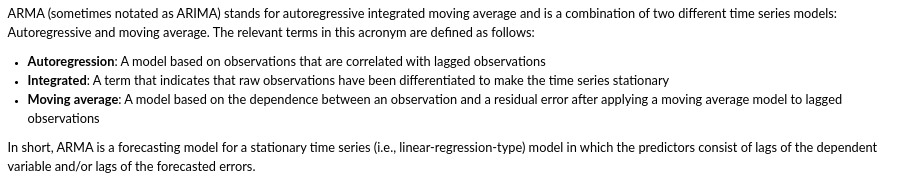

# 10.10 ARMA Part 1

Catpure time-invariant structure of stationary time series  
- Once done, left with a final residue of structureless, useless white noise

## Model Types - MA or AR
Two best models
- Moving average MA(q), q = order of process
- Autoregressive AR(p), p = order of process

0th order = white noise
- Higher the order, more structure is revealed

### MA

- White noise put through a filter with coefficients theta 1, ... theta q

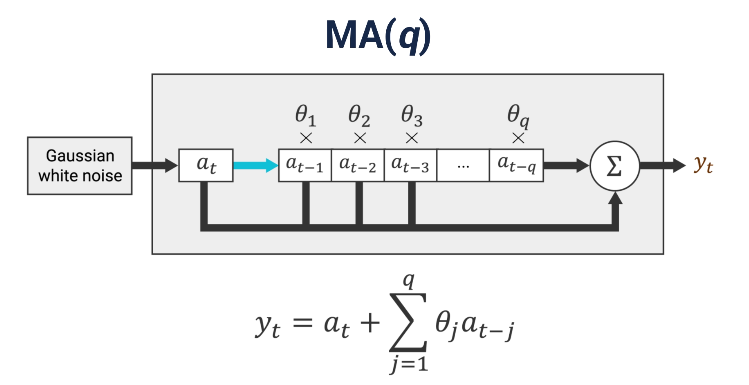

### AR

Auto-regressive because feedbacks to itself (inifinite impulse response)  
Note using phi, not theta, as filter coefs

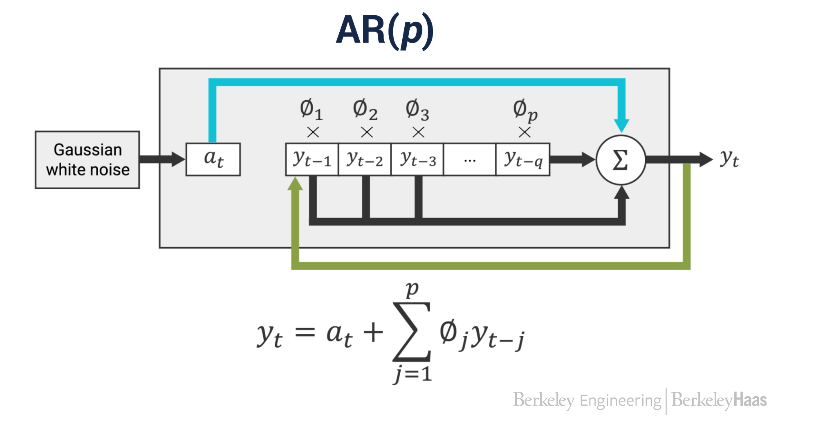

## Examples of Time Series and Models

Not really possible to pick off from one of these plots whether MA or AR or what order if either

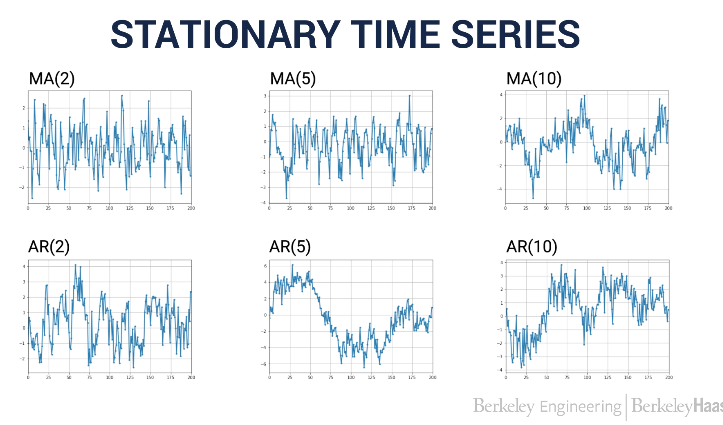

## ACF's of Prior Examples

Notice how for MA q, there are q non-zero values in ACF after 1.0 at lag = 0, which suggests the following procedure
- Look at the lag of the last non-zero value in ACF -> that is the MA order

However, cannot state same for AR

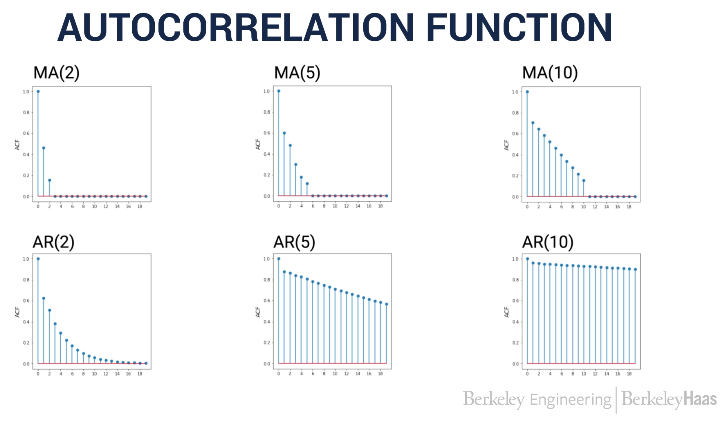

## Partial ACF

Another approach is to look at partial ACF. Reverses prior results, in that the values are non-zero up to the lag of the order of the AR process

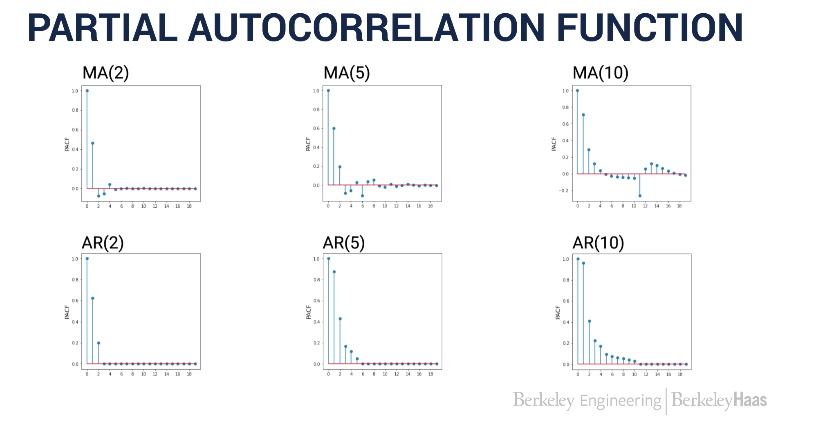

## Problem - Do not have the ACF or PACF

But we have sample values from which to compute the sample ACF and sample PACF
- Now the stopping condition is not identically zero, but in the "blue region" ~ effectively zero
- At least for the lower order models
- What about the higher order models with order 10?
    - Blue region occurs inside of order, so what to do?
    - Apparently nothing, but hope you don't encounter it because you can't detect it reliably

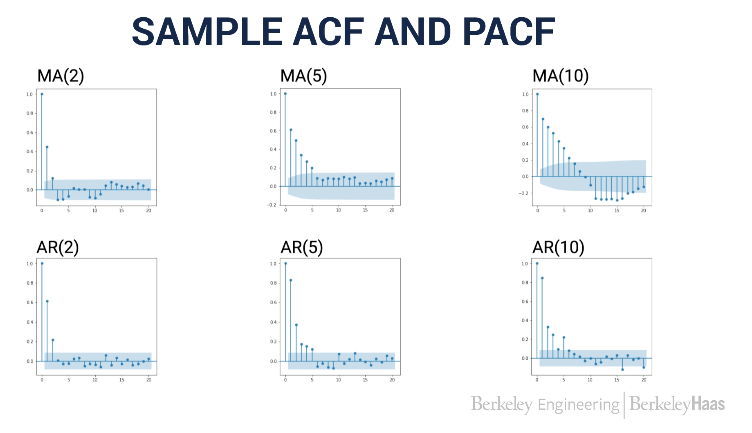

# 10.11 ARMA Part 2

ARMA process is a combination of AR and MA
- Can replicate any zero mean stationary process by setting p and q large enough
- And solving for correct theta, phi
- Strictly larger class of models than either MA or AR

Take left hand side of AR(p) and equate with right hand side of MA(q)

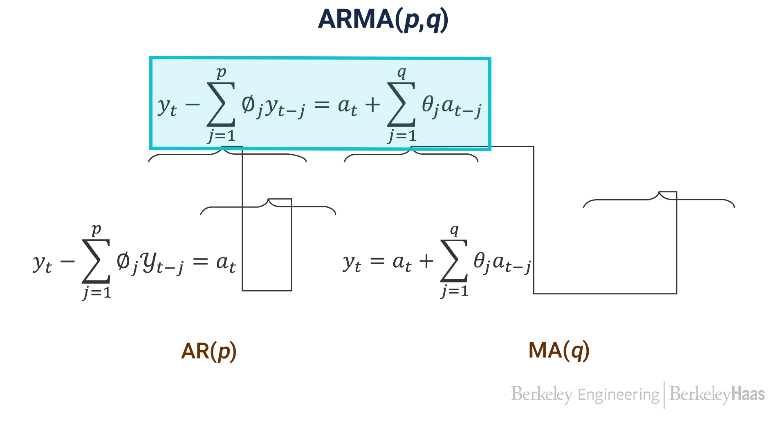

# 10.12 ARMA Part 3

Steps for ARMA
- Check if stationary
- Use sample ACF and PACF to select p and q
- Compute theta, phi for MA and AR parts (via fits)
- Compute the residuals using the above model
    - If model has worked, then residual is white
- Make a forecast

## Return to Sunspot Data

Recall that ACF of residue of model showed not stationary
- Nevertheless, try to apply ARMA to it

Look at ACF and PACF of residue
- Notice that PACF decays rapidly, suggests an AR model of order 1

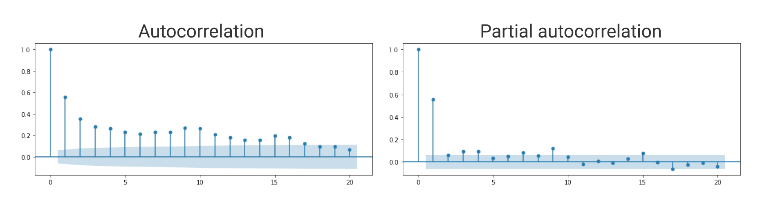

In [53]:
from statsmodels.tsa.arima.model import ARIMA

p = 1
q = 0

# The 0 between p and q is the "i" of the ARMA model
# Take d differences where d = i before doing the fit
# As in differentiate to get stationarity
arma = ARIMA(residue, order=(p, 0, q)).fit()
arma_history = arma.predict()

## Plot the Fit

But don't be fooled by surprisingly tight fit of model
- So good because only making 1 step prediction from each point in residue
- Does he mean just one step ahead?

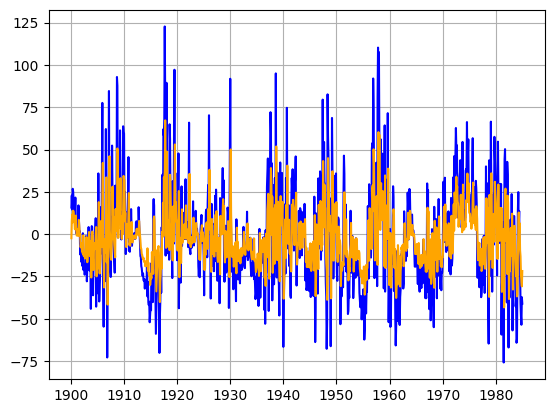

In [54]:
plt.plot(residue, color="b", label="Residue")
plt.plot(arma_history, color="orange", label="ARMA Model of Residue")

## Compute Residue from ARMA Model

Now look at the residual of the model, subtract model from residue

## Note that ultimately this model can't say much for sunspots because it wasn't stationary in the first place

Also note that the reach of the model is commensurate with its order
- Higher order --> look further into future

In [55]:
def interpret_adfuller(dftest) -> dict:
    adfd = dict(
        zip(
            [
                "adf",
                "pvalue",
                "usedlag",
                "nobs",
                "critical values",
            ],
            dftest[0:5],
        )
    )

    rejection_confidence = None
    for ci in [1, 5, 10]:
        # Null hypothesis: non-stationarity exists
        # If can reject, hypothesis is false, so is stationary
        # Can reject if ADF less than crit value and pvalue less than ci
        key = "Reject Null per %d%% Confidence Interval" % ci
        adfd[key] = (
            adfd["adf"] < adfd["critical values"][str(ci) + "%"]
            and adfd["pvalue"] < ci / 100.0
        )
        if adfd[key] and rejection_confidence is None:
            rejection_confidence = ci

    adfd["Process Is"] = (
        "Not Stationary"
        if rejection_confidence is None
        else "Stationary, with %d%% Confidence" % (100 - rejection_confidence)
    )
    return adfd


In [56]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [57]:
sunspots = sm.datasets.sunspots.load_pandas().data
sunspots.index = pd.Index(sm.tsa.datetools.dates_from_range("1700", "2008"))
display(interpret_adfuller(adfuller(sunspots["SUNACTIVITY"], autolag="AIC")))

{'adf': -2.8377807249381943,
 'pvalue': 0.053076421728120673,
 'usedlag': 8,
 'nobs': 300,
 'critical values': {'1%': -3.4523371197407404,
  '5%': -2.871222860740741,
  '10%': -2.571929211111111},
 'Reject Null per 1% Confidence Interval': False,
 'Reject Null per 5% Confidence Interval': False,
 'Reject Null per 10% Confidence Interval': True,
 'Process Is': 'Stationary, with 90% Confidence'}